# Restauant Rating Prediction EDA

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import json
import joblib 

%matplotlib inline

# Data Summary

In [3]:
data=pd.read_csv("zomato.csv")
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [5]:
# Percentage of null values in each of column.
100*data.isnull().sum()/len(data)

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [6]:
# Printing the columns
data.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

# Data Cleaning

In [7]:
df=data.copy()

In [8]:
# Dropping columns that are not needed for prediction
df=df.drop([ 'url','phone', 'location','reviews_list','rest_type'],axis=1)

In [9]:
df.head()
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [10]:
# Dropping restaurants where the rating is not available.
df=df[-df["rate"].isna()]

# Dropping restaurants with less than 50 votes.
df=df[df["votes"]>=50]

# Dropping Votes feature as it will not be needed for prediction.
df.drop("votes",axis=1,inplace=True)

In [11]:
# Dealing with NaN values.

# Replacing commas in 'approx_cost(for two people) with empty string'
df['approx_cost(for two people)']=df['approx_cost(for two people)'].str.replace(",","").astype(float)

# Defined for grouping.
col=["listed_in(city)","listed_in(type)"]

# It calculates the median of the 'approx_cost(for two people) column for each group defined by the columns in 'col' and assigns it to a new Series 'ser' 
ser=df.groupby(col)['approx_cost(for two people)'].transform('median')

# Filling the missing values with corresponding group median values calculated in the previous line of code
df['approx_cost(for two people)']=df['approx_cost(for two people)'].fillna(ser)

# Replaces any NaN values in the 'dish_liked' column with empty string.
df["dish_liked"].replace(np.nan,"",inplace=True)

# Drops any remaining rows with NaN values in any column. 
df.dropna(inplace=True)

In [12]:

def r_category(rating):
    ''' Function takes rating as input and categorizes it based on specific conditions.'''
    if rating>=4.0:
        return "Excellent"
    elif rating>=3.0:
        return "Good"
    elif rating>=2.5:
        return "Average"
    else:
        return "Poor"

def p_category(price):
    ''' Function takes price as input and categorizes it based on specific conditions.'''
    if price<=100.0:
        return "Cheap"
    elif price<=250.0:
        return "Resonable"
    elif price<=500.0:
        return "Affordable"
    else:
        return "Expensive"

In [13]:
df

,address,name,online_order,book_table,rate,dish_liked,cuisines,approx_cost(for two people),menu_item,listed_in(type),listed_in(city)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,"Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,Masala Dosa,"South Indian, North Indian",300.0,[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...
51705,"2nd Floor, Iona, Virginia Mall, Whitefield Mai...",Izakaya Gastro Pub,Yes,Yes,3.8 /5,"Beer, Chicken Guntur, Paneer Tikka, Fish, Nood...","North Indian, Continental, Mediterranean",1200.0,[],Pubs and bars,Whitefield
51707,"Bengaluru Marriott Hotel, 75, 8th Road, EPIP A...",M Bar - Bengaluru Marriott Hotel Whitefield,No,No,3.9 /5,Rooftop Ambience,Finger Food,2000.0,[],Pubs and bars,Whitefield
51708,"Keys Hotel, 6, 1st Phase Industrial Area, Near...",Keys Cafe - Keys Hotel,No,No,2.8 /5,"Salads, Coffee, Breakfast Buffet, Halwa, Chick...","Chinese, Continental, North Indian",1200.0,[],Pubs and bars,Whitefield
51711,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5 /5,"Biryani, Andhra Meal","Andhra, South Indian, Chinese, North Indian",800.0,[],Pubs and bars,Whitefield


In [14]:
# Deriving features

# Calculating the cost per person by divding the required column by 2.
df['Cost_Per_Person']=df['approx_cost(for two people)']/2

# Extracting the first three characters and converting them to float.
df["rate"]=df["rate"].str[0:3].astype(float)
# Applying the r_category function to the rate column and assigns the resulting category to the new column Category.
df["Category"]=df["rate"].apply(r_category)

# Applying the p_category function to the cost_per_person column and assigns resulting category to the new column "Price_category"
df["Price_Category"]=df["Cost_Per_Person"].apply(p_category)

# Determining whether a menu is available. Maps the menu_item column using lambda function to check if the value is '[]'. Setting values to Yes and No.
df["Menu"]=df["menu_item"].map(lambda x: "No" if x=='[]' else "Yes")

# Counting the number of dishes of liked by customers at a restaurant. 
df['dish_liked']=df['dish_liked'].map(lambda x:0 if x=="" else len(x.split(", ")))

# Counting the number of varieties served at a restaurant.
df['No_of_Varieties']=df['cuisines'].apply(lambda x:len(x.split(", ")))

In [15]:
# Renaming letters for better understanding

change = {
    'name': 'Name',
    'address': 'Address',
    'online_order': 'Delivery',
    'book_table': 'Booking',
    'rate': 'Rating',
    'dish_liked': 'No_of_Best_Sellers',
    'cuisines': 'Cuisines',
    'approx_cost(for two people)': 'Average_Cost',
    'listed_in(type)': 'Type',
    'listed_in(city)': 'City'
}

df.rename(columns=change, inplace=True)

In [16]:
df['Rating'].unique()

array([4.1, 3.8, 3.7, 4.6, 4. , 4.2, 3.9, 3. , 3.6, 2.8, 4.4, 3.1, 4.3,
       3.2, 2.9, 2.6, 3.3, 3.5, 4.5, 2.5, 3.4, 2.7, 4.7, 2.4, 2.2, 2.3,
       4.8, 4.9, 2.1, 2. , 1.8])

In [17]:
# Resetting the index of the DataFrame and modifying it in place.
df.reset_index(drop=True,inplace=True)

In [18]:
df

,Address,Name,Delivery,Booking,Rating,No_of_Best_Sellers,Cuisines,Average_Cost,menu_item,Type,City,Cost_Per_Person,Category,Price_Category,Menu,No_of_Varieties
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,7,"North Indian, Mughlai, Chinese",800.0,[],Buffet,Banashankari,400.0,Excellent,Affordable,No,3
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,7,"Chinese, North Indian, Thai",800.0,[],Buffet,Banashankari,400.0,Excellent,Affordable,No,3
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,7,"Cafe, Mexican, Italian",800.0,[],Buffet,Banashankari,400.0,Good,Affordable,No,3
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,1,"South Indian, North Indian",300.0,[],Buffet,Banashankari,150.0,Good,Resonable,No,2
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,2,"North Indian, Rajasthani",600.0,[],Buffet,Banashankari,300.0,Good,Affordable,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146,"2nd Floor, Iona, Virginia Mall, Whitefield Mai...",Izakaya Gastro Pub,Yes,Yes,3.8,7,"North Indian, Continental, Mediterranean",1200.0,[],Pubs and bars,Whitefield,600.0,Good,Expensive,No,3
24147,"Bengaluru Marriott Hotel, 75, 8th Road, EPIP A...",M Bar - Bengaluru Marriott Hotel Whitefield,No,No,3.9,1,Finger Food,2000.0,[],Pubs and bars,Whitefield,1000.0,Good,Expensive,No,1
24148,"Keys Hotel, 6, 1st Phase Industrial Area, Near...",Keys Cafe - Keys Hotel,No,No,2.8,7,"Chinese, Continental, North Indian",1200.0,[],Pubs and bars,Whitefield,600.0,Average,Expensive,No,3
24149,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,2,"Andhra, South Indian, Chinese, North Indian",800.0,[],Pubs and bars,Whitefield,400.0,Average,Affordable,No,4


In [19]:
# Checking unique cuisines for cleaning.
df['Cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ..., 'Tibetan, Nepalese',
       'Andhra, North Indian, South Indian', 'Thai, Chinese, Momos'],
      dtype=object)

In [20]:
#cleaning cuisine columns by properly categorizing food items

def func1(string):
    l=string.split(", ")
    
    if "Afghan" in l:
        l=list(map(lambda x: x.replace('Afghan', 'Afghani'), l))
        
    if "Bubble Tea" in l:
        l=list(map(lambda x: x.replace('Bubble Tea', 'Beverages'), l))
        
    if "Coffee" in l:
        l=list(map(lambda x: x.replace('Coffee', 'Beverages'), l))
        
    if "Cafe" in l:
        l=list(map(lambda x: x.replace('Cafe', 'Beverages'), l))
       
    if "Tea" in l:
        l=list(map(lambda x: x.replace('Tea', 'Beverages'), l))
        
    if "Bubble Beverages" in l:
        l=list(map(lambda x: x.replace('Bubble Beverages', 'Beverages'), l))
       
    if "Ice Cream" in l:
        l=list(map(lambda x: x.replace('Ice Cream', 'Desserts'), l))
        
    if "Mithai" in l:
        l=list(map(lambda x: x.replace('Mithai', 'Desserts'), l))
      
    if "Bar Food" in l:
        l=list(map(lambda x: x.replace('Bar Food', 'Fast Food'), l))
        
    if "Burger" in l:
        l=list(map(lambda x: x.replace('Burger', 'Fast Food'), l))
       
    if "Finger Food" in l:
        l=list(map(lambda x: x.replace('Finger Food', 'Fast Food'), l))
        
    if "Momos" in l:
        l=list(map(lambda x: x.replace('Momos', 'Fast Food'), l))
        
    if "Rolls" in l:
        l=list(map(lambda x: x.replace('Rolls', 'Fast Food'), l))
    
    if "Wraps" in l:
        l=list(map(lambda x: x.replace('Wraps', 'Fast Food'), l))
        
    if "Street Food" in l:
        l=list(map(lambda x: x.replace('Street Food', 'Fast Food'), l))
 
    if "Juices" in l:
        l=list(map(lambda x: x.replace('Juices', 'Healthy Food'), l))
       
    if "Salad" in l:
        l=list(map(lambda x: x.replace('Salad', 'Healthy Food'), l))
     
    if "Sandwich" in l:
        l=list(map(lambda x: x.replace('Sandwich', 'Healthy Food'), l))
      
    if "Grill" in l:
        l=list(map(lambda x: x.replace('Grill', 'BBQ'), l))
    
    if "Steak" in l:
        l=list(map(lambda x: x.replace('Steak', 'BBQ'), l))
        
    if "Sushi" in l:
        l=list(map(lambda x: x.replace('Sushi', 'Japanese'), l))
        
    if "Tex-Mex" in l:
        l=list(map(lambda x: x.replace('Tex-Mex', 'Mexican'), l))
        
    if "Roast Chicken" in l:
        l=list(map(lambda x: x.replace('Roast Chicken', 'Chinese'), l))
        
    if "Charcoal Chicken" in l:
        l=list(map(lambda x: x.replace('Charcoal Chicken', 'Chinese'), l))
        
    if "Pizza" in l:
        l=list(map(lambda x: x.replace('Pizza', 'Italian'), l))
        
    if "Biryani" in l:
        l=list(map(lambda x: x.replace('Biryani', 'South Indian'), l))
        
    if "Kebab" in l:
        l=list(map(lambda x: x.replace('Kebab', 'North Indian'), l))
    
    return ", ".join(set(l))
    
df["Cuisines"]=df["Cuisines"].apply(func1)

In [21]:
df

,Address,Name,Delivery,Booking,Rating,No_of_Best_Sellers,Cuisines,Average_Cost,menu_item,Type,City,Cost_Per_Person,Category,Price_Category,Menu,No_of_Varieties
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,7,"North Indian, Mughlai, Chinese",800.0,[],Buffet,Banashankari,400.0,Excellent,Affordable,No,3
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,7,"North Indian, Thai, Chinese",800.0,[],Buffet,Banashankari,400.0,Excellent,Affordable,No,3
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,7,"Italian, Beverages, Mexican",800.0,[],Buffet,Banashankari,400.0,Good,Affordable,No,3
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,1,"North Indian, South Indian",300.0,[],Buffet,Banashankari,150.0,Good,Resonable,No,2
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,2,"North Indian, Rajasthani",600.0,[],Buffet,Banashankari,300.0,Good,Affordable,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146,"2nd Floor, Iona, Virginia Mall, Whitefield Mai...",Izakaya Gastro Pub,Yes,Yes,3.8,7,"North Indian, Mediterranean, Continental",1200.0,[],Pubs and bars,Whitefield,600.0,Good,Expensive,No,3
24147,"Bengaluru Marriott Hotel, 75, 8th Road, EPIP A...",M Bar - Bengaluru Marriott Hotel Whitefield,No,No,3.9,1,Fast Food,2000.0,[],Pubs and bars,Whitefield,1000.0,Good,Expensive,No,1
24148,"Keys Hotel, 6, 1st Phase Industrial Area, Near...",Keys Cafe - Keys Hotel,No,No,2.8,7,"North Indian, Chinese, Continental",1200.0,[],Pubs and bars,Whitefield,600.0,Average,Expensive,No,3
24149,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,2,"Andhra, North Indian, Chinese, South Indian",800.0,[],Pubs and bars,Whitefield,400.0,Average,Affordable,No,4


In [22]:
df=df[['Name','Address','Menu','Delivery', 'Booking', 'No_of_Best_Sellers', 'No_of_Varieties', 'Cuisines',
     'Cost_Per_Person', 'Type', 'City', 'Rating','Category','Price_Category']]
df.head()

,Name,Address,Menu,Delivery,Booking,No_of_Best_Sellers,No_of_Varieties,Cuisines,Cost_Per_Person,Type,City,Rating,Category,Price_Category
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",No,Yes,Yes,7,3,"North Indian, Mughlai, Chinese",400.0,Buffet,Banashankari,4.1,Excellent,Affordable
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",No,Yes,No,7,3,"North Indian, Thai, Chinese",400.0,Buffet,Banashankari,4.1,Excellent,Affordable
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",No,Yes,No,7,3,"Italian, Beverages, Mexican",400.0,Buffet,Banashankari,3.8,Good,Affordable
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",No,No,No,1,2,"North Indian, South Indian",150.0,Buffet,Banashankari,3.7,Good,Resonable
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",No,No,No,2,2,"North Indian, Rajasthani",300.0,Buffet,Banashankari,3.8,Good,Affordable


# Data Preprocessing

In [23]:
# Splitting the values in the 'Cuisines' column of the DataFrame based on the delimiter.
multi_label=df["Cuisines"].str.split(", ")

In [24]:
multi_label

0                     [North Indian, Mughlai, Chinese]
1                        [North Indian, Thai, Chinese]
2                        [Italian, Beverages, Mexican]
3                         [North Indian, South Indian]
4                           [North Indian, Rajasthani]
                             ...                      
24146       [North Indian, Mediterranean, Continental]
24147                                      [Fast Food]
24148             [North Indian, Chinese, Continental]
24149    [Andhra, North Indian, Chinese, South Indian]
24150                                      [Fast Food]
Name: Cuisines, Length: 24151, dtype: object

In [25]:
# Creating an instance of the 'MultiLabelBinarizer' class. 
mlb = MultiLabelBinarizer()

# Applying fit_transform method of the 'MultiLabelBinarizer' instance. The method fits MultiLabelBinarizer on the data and transforms it into a binary matrix representation.
inter_data=mlb.fit_transform(multi_label)

# Creating DataFrame from the transformed data, using the column names from mlb.classes_
multi_label_df=pd.DataFrame(inter_data,columns=mlb.classes_)

In [26]:
mlb.classes_

array(['Afghani', 'African', 'American', 'Andhra', 'Arabian', 'Asian',
       'Assamese', 'Awadhi', 'BBQ', 'Bakery', 'Belgian', 'Bengali',
       'Beverages', 'Bihari', 'Bohri', 'British', 'Burmese', 'Cantonese',
       'Chettinad', 'Chinese', 'Continental', 'Desserts', 'European',
       'Fast Food', 'French', 'German', 'Goan', 'Greek', 'Gujarati',
       'Healthy Food', 'Hyderabadi', 'Indonesian', 'Iranian', 'Italian',
       'Japanese', 'Jewish', 'Kashmiri', 'Kerala', 'Konkan', 'Korean',
       'Lebanese', 'Lucknowi', 'Maharashtrian', 'Malaysian',
       'Mangalorean', 'Mediterranean', 'Mexican', 'Middle Eastern',
       'Modern Indian', 'Mughlai', 'Naga', 'Nepalese', 'North Eastern',
       'North Indian', 'Oriya', 'Parsi', 'Portuguese', 'Rajasthani',
       'Russian', 'Seafood', 'Sindhi', 'Singaporean', 'South American',
       'South Indian', 'Spanish', 'Sri Lankan', 'Tamil', 'Thai',
       'Tibetan', 'Turkish', 'Vegan', 'Vietnamese'], dtype=object)

In [27]:
multi_label_df

,Afghani,African,American,Andhra,Arabian,Asian,Assamese,Awadhi,BBQ,Bakery,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24149,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
# Combining the DataFrames to single DataFrame. 
data=df[['Name','Menu','Delivery', 'Booking','Type', 'City','No_of_Best_Sellers', 'No_of_Varieties',
         'Cost_Per_Person', 'Rating','Category','Price_Category']]
dataframe=pd.concat([data,multi_label_df],axis=1)
dataframe.head()

,Name,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,No,Yes,Yes,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,No,Yes,No,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,No,Yes,No,Buffet,Banashankari,7,3,400.0,3.8,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,No,No,No,Buffet,Banashankari,1,2,150.0,3.7,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,No,Buffet,Banashankari,2,2,300.0,3.8,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Saving DataFrame to CSV file without including the index column.
dataframe.to_csv("display.csv",index=False)

In [30]:
# Creating a new DataFrame, which includes address.
d=df[['Name','Address','Menu','Delivery', 'Booking','Type', 'City','No_of_Best_Sellers', 'No_of_Varieties',
      'Cost_Per_Person', 'Rating','Category','Price_Category']]
dataframe=pd.concat([d,multi_label_df],axis=1)

In [31]:
dataframe

,Name,Address,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",No,Yes,Yes,Buffet,Banashankari,7,3,400.0,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",No,Yes,No,Buffet,Banashankari,7,3,400.0,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",No,Yes,No,Buffet,Banashankari,7,3,400.0,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",No,No,No,Buffet,Banashankari,1,2,150.0,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",No,No,No,Buffet,Banashankari,2,2,300.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24146,Izakaya Gastro Pub,"2nd Floor, Iona, Virginia Mall, Whitefield Mai...",No,Yes,Yes,Pubs and bars,Whitefield,7,3,600.0,...,0,0,0,0,0,0,0,0,0,0
24147,M Bar - Bengaluru Marriott Hotel Whitefield,"Bengaluru Marriott Hotel, 75, 8th Road, EPIP A...",No,No,No,Pubs and bars,Whitefield,1,1,1000.0,...,0,0,0,0,0,0,0,0,0,0
24148,Keys Cafe - Keys Hotel,"Keys Hotel, 6, 1st Phase Industrial Area, Near...",No,No,No,Pubs and bars,Whitefield,7,3,600.0,...,0,0,0,0,0,0,0,0,0,0
24149,Bhagini,"139/C1, Next To GR Tech Park, Pattandur Agraha...",No,No,No,Pubs and bars,Whitefield,2,4,400.0,...,0,1,0,0,0,0,0,0,0,0


In [32]:
# Calculating the number of duplicated rows in the DataFrame based on the columns Name and Address.
dataframe.duplicated(subset=['Name','Address']).sum()

19279

In [33]:
# Removing the duplicates
dataframe.drop_duplicates(subset=['Name','Address'],inplace=True)

In [34]:
len(dataframe)

4872

In [35]:
# Creating one_hot variables for one-hot encoding. The columns represent categorical values. One-hot encoding converts categorical variables into binary columns, where each column represents a unique category and is assigned a value of 1 if category is present and 0 otherwise.
one_hot=dataframe[['Delivery', 'Booking', 'City']]

# Creating numeric variable. Columns represent numerical values that can be used directly in numerical computations or analysis.
numeric=dataframe[['No_of_Best_Sellers', 'No_of_Varieties', 'Cost_Per_Person', 'Rating']]

In [36]:
# Initializes the OneHotEncoder class.
encoder= OneHotEncoder()

# Applying fit_transform method of the OneHotEncoder to the one_hot dataframe. Converts categorical values into a sparse matrix representation using one-hot encoding.
one_hot_df=pd.DataFrame(encoder.fit_transform(one_hot).toarray(),index=list(dataframe.index))

In [37]:
one_hot_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24086,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24088,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24092,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24094,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
# combines the 'numeric' 'multi_label_df' and 'one_hot_df' dataframes horizontally (along the column axis) to create a new DataFrame.
df_inter=pd.concat([numeric,multi_label_df.iloc[list(dataframe.index),:],one_hot_df],axis=1)

# resets index of the df_inter DataFrame to be sequential from 0 and modifies the DataFrame in place.
df_inter.reset_index(drop=True,inplace=True)

df_inter.head()

,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,Afghani,African,American,Andhra,Arabian,Asian,...,24,25,26,27,28,29,30,31,32,33
0,7,3,400.0,4.1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,3,400.0,4.1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,3,400.0,3.8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,150.0,3.7,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2,300.0,3.8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# creating a numpy array X by dropping column with the label 'Rating' from the df_inter DataFrame. The resulting 'X contains the values of all the other columns in df_inter, which will be used as the input features for a machine learning model.' 
X=df_inter.drop("Rating",axis=1).values

# creates a numpy array y by selecting the values from the column with the label 'Rating' in the df_inter. The resulting array contains the target variable values, which are the ratings corresponding to each set of features in 'X'. The 'y' in the array will be used as the output for the machine learning model.
y=df_inter["Rating"].values

In [40]:
X

array([[  7.,   3., 400., ...,   0.,   0.,   0.],
       [  7.,   3., 400., ...,   0.,   0.,   0.],
       [  7.,   3., 400., ...,   0.,   0.,   0.],
       ...,
       [  7.,   3., 300., ...,   0.,   0.,   1.],
       [  7.,   3., 900., ...,   0.,   0.,   1.],
       [  2.,   4., 400., ...,   0.,   0.,   1.]])

In [41]:
mlb.classes_

array(['Afghani', 'African', 'American', 'Andhra', 'Arabian', 'Asian',
       'Assamese', 'Awadhi', 'BBQ', 'Bakery', 'Belgian', 'Bengali',
       'Beverages', 'Bihari', 'Bohri', 'British', 'Burmese', 'Cantonese',
       'Chettinad', 'Chinese', 'Continental', 'Desserts', 'European',
       'Fast Food', 'French', 'German', 'Goan', 'Greek', 'Gujarati',
       'Healthy Food', 'Hyderabadi', 'Indonesian', 'Iranian', 'Italian',
       'Japanese', 'Jewish', 'Kashmiri', 'Kerala', 'Konkan', 'Korean',
       'Lebanese', 'Lucknowi', 'Maharashtrian', 'Malaysian',
       'Mangalorean', 'Mediterranean', 'Mexican', 'Middle Eastern',
       'Modern Indian', 'Mughlai', 'Naga', 'Nepalese', 'North Eastern',
       'North Indian', 'Oriya', 'Parsi', 'Portuguese', 'Rajasthani',
       'Russian', 'Seafood', 'Sindhi', 'Singaporean', 'South American',
       'South Indian', 'Spanish', 'Sri Lankan', 'Tamil', 'Thai',
       'Tibetan', 'Turkish', 'Vegan', 'Vietnamese'], dtype=object)

# Data Insights

In [42]:
idf=pd.read_csv("display.csv")
idf.head()

,Name,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,No,Yes,Yes,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,No,Yes,No,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,No,Yes,No,Buffet,Banashankari,7,3,400.0,3.8,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,No,No,No,Buffet,Banashankari,1,2,150.0,3.7,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,No,Buffet,Banashankari,2,2,300.0,3.8,...,0,0,0,0,0,0,0,0,0,0


In [43]:
col=mlb.classes_

In [44]:
df=idf["Delivery"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Online Delivery')
py.iplot(fig)

In [45]:
df=idf["Booking"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Table Booking')
py.iplot(fig)

In [46]:
df=idf["Category"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Category')
py.iplot(fig)

In [47]:
df=idf["Price_Category"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Price Category')
py.iplot(fig)

In [48]:
#Most Expensive Cities

inter=idf.groupby("City")[["Cost_Per_Person"]].mean()
sol=inter.sort_values(by="Cost_Per_Person",ascending=False).head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Cost_Per_Person
City,
Lavelle Road,515.641026
Church Street,513.009165
Residency Road,507.262045
Brigade Road,502.995868
MG Road,500.569185


In [49]:
#Most Affordable Cities

inter=idf.groupby("City")[["Cost_Per_Person"]].mean()
sol=inter.sort_values(by="Cost_Per_Person").head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Cost_Per_Person
City,
Banashankari,248.263889
Basavanagudi,279.953198
Bannerghatta Road,285.983333
JP Nagar,292.497156
Jayanagar,295.845656


In [50]:
fig = px.scatter(idf, x="Cost_Per_Person", y="Rating")
py.iplot(fig)

In [51]:
inter=idf.groupby(['No_of_Best_Sellers', 'No_of_Varieties'])[["Menu"]].count()
inter.rename(columns={"Menu":"Count"},inplace=True)
inter.reset_index(inplace=True)
    
fig = px.bar(inter,x="No_of_Varieties",y="Count",color="No_of_Best_Sellers",barmode="group")
py.iplot(fig)

In [52]:
# Choose City

city="Banashankari"

inter=idf[idf["City"]=="Banashankari"]

d1=inter.groupby("Type")["Type"].count().sort_values(ascending=False)
d2=inter.groupby("Type")["Cost_Per_Person"].agg(['min','median','max'])

#cpp=cost per person
sol=pd.concat([d1,d2],axis=1)
cols=['No','Min_cpp','Median_cpp','Max_cpp']
sol.columns=cols
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,No,Min_cpp,Median_cpp,Max_cpp
Type,,,,
Delivery,242,50.000000,225.000000,750.000000
Dine-out,144,50.000000,200.000000,650.000000
Cafes,18,100.000000,287.500000,400.000000
Desserts,17,75.000000,200.000000,400.000000
Buffet,6,150.000000,350.000000,400.000000
Drinks & nightlife,5,400.000000,550.000000,650.000000


In [53]:
#choose city and Type
City="Banashankari"
Type="Delivery"

inter=idf[(idf["City"]==City)&(idf["Type"]==Type)]['Cost_Per_Person']
fig = px.histogram(inter, x='Cost_Per_Person')
py.iplot(fig)

In [54]:
#Choose City

city="Sarjapur Road"

inter=idf[idf["City"]=="Sarjapur Road"]
ser=inter.groupby(["City"])[col].sum()
index=ser.columns
val=ser.values.T.flatten()
series=pd.Series(val,index)
ii=series.sort_values(ascending=False).head()
fig = px.bar(df,x=ii.index,y=ii.values)
py.iplot(fig)

In [55]:
#Choose City and Restaurant Type

inter=idf[(idf["North Indian"]==1)&(idf['City']=='Bellandur')]
ser=inter.groupby('Name')[['Rating']].max()
sol=ser.sort_values(by='Rating',ascending=False).head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Rating
Name,
Byg Brewski Brewing Company,4.900000
The Black Pearl,4.800000
AB's - Absolute Barbecues,4.700000
Opus Food Stories,4.700000
Vapour Brewpub and Diner,4.600000


In [56]:
#Choose City and Restaurant Type

city="Sarjapur Road"
type="Delivery"

inter=idf[idf["City"]=="Sarjapur Road"]
ser=inter.groupby(["Type"])[col].sum()
df_inter=ser.T
inter=df_inter[type]

ii=inter.sort_values(ascending=False).head()
fig = px.bar(df,x=ii.index,y=ii.values)
py.iplot(fig)

In [57]:
#Choose city
City="Old Airport Road"

ser=idf.groupby(["City","Type"])[col].sum()
ser
dicton={}

for i in range(len(ser)):
    index=ser.columns
    val=ser.iloc[i].values.T.flatten()
    series=pd.Series(val,index)
    vall=list(series.sort_values(ascending=False).head().index)
    dicton[ser.index[i]]=vall
    
sol=pd.DataFrame(dicton,index=['1st','2nd','3rd','4th','5th'])
frame=sol.T
frame.loc[City]

,1st,2nd,3rd,4th,5th
Buffet,North Indian,Continental,Chinese,Italian,Mughlai
Cafes,Beverages,Desserts,Fast Food,Italian,Continental
Delivery,North Indian,Fast Food,Chinese,South Indian,Beverages
Desserts,Desserts,Beverages,Fast Food,Bakery,Italian
Dine-out,North Indian,Chinese,Fast Food,South Indian,Continental
Drinks & nightlife,Continental,North Indian,Chinese,Fast Food,Italian
Pubs and bars,Continental,North Indian,Chinese,Fast Food,American


In [58]:
city="Sarjapur Road"

cols=idf["Type"].unique()
df=pd.DataFrame()

inter=idf[idf["City"]=="Sarjapur Road"]
inter=inter.groupby("Type")[col].sum().T

for i in cols:
    ser=inter[i].sort_values(ascending=False).head()
    df_inter=pd.DataFrame(ser)
    df_inter.reset_index(inplace=True)
    df_inter.rename(columns={i:"Count","index":"Cuisine"},inplace=True)
    df_inter["Type"]=i
    df=pd.concat([df,df_inter],axis=0)
    
fig = px.bar(df,x="Type",y="Count",color="Cuisine")
py.iplot(fig)

In [59]:
#Choose city

City="BTM"
sel=["North Indian","South Indian","Chinese","Fast Food","Italian"]
df=pd.DataFrame()
order={'Price_Category':['Cheap','Resonable','Affordable', 'Expensive']}

for i in sel:
    inter=idf[idf[i]==1]
    inter=inter.groupby(["Price_Category"])[["Menu"]].count()
    inter=inter.reset_index()
    inter.rename(columns={"Menu":"Count"},inplace=True)
    inter["Cuisine_Type"]=i
    df=pd.concat([df,inter],axis=0)


fig = px.bar(x=df["Cuisine_Type"], y=df["Count"],color=df["Price_Category"],barmode="group",
             category_orders={"Price_Category": ["Cheap", "Resonable", "Affordable", "Expensive"]})
py.iplot(fig)

In [60]:
#Choose city

City="BTM"
sel=["North Indian","South Indian","Chinese","Fast Food","Italian"]
df=pd.DataFrame()

for i in sel:
    inter=idf[idf[i]==1]
    inter=inter.groupby(["Category"])[["Menu"]].count()
    inter=inter.reset_index()
    inter.rename(columns={"Menu":"Count"},inplace=True)
    inter["Cuisine_Type"]=i
    df=pd.concat([df,inter],axis=0)


fig = px.bar(x=df["Cuisine_Type"], y=df["Count"], color=df["Category"],barmode="group")
py.iplot(fig)

# Modelling

In [61]:
# The purpose of this function is to provide a convenient way to retrieve a list of machine learning models and their names for further usage, such as model selection or evaluation.
def get_models():
    models,names=[],[]
    
    models.append(RandomForestRegressor())
    names.append("RandomForestRegressor")
    
    models.append(XGBRegressor())
    names.append("XGBRegressor")
    
    models.append(LGBMRegressor())
    names.append("LGBMRegressor")
    
    return models,names

In [91]:
# Performing cross validation for each model in the 'model's' list and stores the resulting scores in the 'scores' list.
models,names=get_models()
scores=[]

for i in range(len(models)):
    # cross_val_score is called to perform cross-validation for the current model. Calculates the negative MSE score for the model using the specified parameters.
    score=cross_val_score(models[i],X,y,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
    scores.append(score)

In [92]:
score

array([-0.13486578, -0.14259993, -0.1242926 , -0.1326539 , -0.13145023])

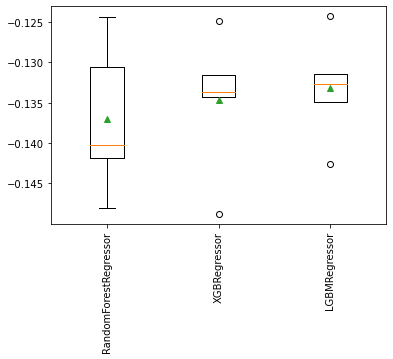

In [93]:
# To create a box plot of the scores obtained from cross validation.
plt.boxplot(scores,labels=names,showmeans=True)
plt.xticks(rotation="vertical");

# Hyperparameter Optimization

In [108]:
# Function to find the optimal hyperparameters for a LightGBM regression model. The goal is to find the hyperparameters sthat minimize the negative MSE, indicating the best-forming model.
def objective(trial):
    
    # The hyperparameters for tuning.
    params={ "n_estimators": trial.suggest_int("n_estimators", 100, 400),
             "max_depth": trial.suggest_int("max_depth", 4, 10),
             "learning_rate":trial.suggest_float("learning_rate", 0.01, 1.0,log=True),
             "subsample":trial.suggest_float("subsample", 0.5, 1.0),
             "reg_alpha": trial.suggest_float("reg_alpha",0.0,1.0)} 
    # LightGBM regression model is then instantiated with the above hyperparameters.
    model=LGBMRegressor(random_state=1,**params)
    # To perform cross-validation and calculate MSE.
    score=cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
    return score.mean()

In [112]:
# Optuna study object for hyperparameter optimization. TPE (Tree-structured Parzen Estimator)
study = optuna.create_study(study_name="Hyperparameter optimization",direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))

# For starting optimization process. During the optimization process, Optuna will automatically search and suggest new hyperparameter combinations based on the results of previous trials.
study.optimize(objective, n_trials=50,show_progress_bar=True)

[I 2023-06-17 21:49:17,599] A new study created in memory with name: Hyperparameter optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-06-17 21:49:17,854] Trial 0 finished with value: -0.14173724246772512 and parameters: {'n_estimators': 212, 'max_depth': 10, 'learning_rate': 0.29106359131330695, 'subsample': 0.7993292420985183, 'reg_alpha': 0.15601864044243652}. Best is trial 0 with value: -0.14173724246772512.
[I 2023-06-17 21:49:18,027] Trial 1 finished with value: -0.13752749157659583 and parameters: {'n_estimators': 146, 'max_depth': 4, 'learning_rate': 0.5399484409787431, 'subsample': 0.8005575058716043, 'reg_alpha': 0.7080725777960455}. Best is trial 1 with value: -0.13752749157659583.
[I 2023-06-17 21:49:18,250] Trial 2 finished with value: -0.1429947550773923 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.46225890010208287, 'subsample': 0.6061695553391381, 'reg_alpha': 0.18182496720710062}. Best is trial 1 with value: -0.13752749157659583.
[I 2023-06-17 21:49:18,456] Trial 3 finished with value: -0.13269043077111345 and parameters: {'n_estimators': 155, 'max_depth': 6, 'lear

[I 2023-06-17 21:49:26,185] Trial 29 finished with value: -0.13278099163913376 and parameters: {'n_estimators': 223, 'max_depth': 10, 'learning_rate': 0.053086953004826805, 'subsample': 0.8039899811473055, 'reg_alpha': 0.11315151444651206}. Best is trial 18 with value: -0.13262064927136277.
[I 2023-06-17 21:49:26,533] Trial 30 finished with value: -0.1372911478319533 and parameters: {'n_estimators': 343, 'max_depth': 10, 'learning_rate': 0.1588253858494877, 'subsample': 0.828522005149925, 'reg_alpha': 0.3095485224780801}. Best is trial 18 with value: -0.13262064927136277.
[I 2023-06-17 21:49:26,899] Trial 31 finished with value: -0.13256281463169936 and parameters: {'n_estimators': 357, 'max_depth': 9, 'learning_rate': 0.03348950619853073, 'subsample': 0.7518575631004538, 'reg_alpha': 0.4029883757119249}. Best is trial 31 with value: -0.13256281463169936.
[I 2023-06-17 21:49:27,248] Trial 32 finished with value: -0.13298855959886813 and parameters: {'n_estimators': 339, 'max_depth': 9,

In [96]:
# Printing the best value. 
print(f"Best value: {study.best_trial.value}")

# Printing the best set of hyperparameters.
print(f"Best hyperparameters:\n {json.dumps(study.best_trial.params, indent=2)}")

Best value: -0.1322419916370909
Best hyperparameters:
 {
  "n_estimators": 352,
  "max_depth": 10,
  "learning_rate": 0.030572290798128673,
  "subsample": 0.7097145342779452,
  "reg_alpha": 0.5471311586862366
}


In [97]:
# Visualizing the history of the optimization process.
plot_optimization_history(study)

In [98]:
# Visualizing to understand the relationship between different hyperparameters and their impact on the performance metric.
plot_parallel_coordinate(study)

In [99]:
# Understanding the impact of each hyperparameter on the overall performance.
plot_param_importances(study)

# Final Model

In [100]:
# **study.best_trial.params unpacks the best hyperparameters found during optimization process.
model=LGBMRegressor(**study.best_trial.params)

# Training the model using training data 'X' and the corresponding target variable 'y'. 
model.fit(X,y)

LGBMRegressor(learning_rate=0.030572290798128673, max_depth=10,
              n_estimators=352, reg_alpha=0.5471311586862366,
              subsample=0.7097145342779452)

In [101]:
# Saving python objects to disk. 
joblib.dump(model,'model.pkl')
joblib.dump(mlb,'mlb.pkl')
joblib.dump(encoder,'encoder.pkl')

['encoder.pkl']